In [9]:
import tensorflow as tf
from rich.jupyter import display
from sklearn.linear_model import SGDRegressor
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Get dataset
dataset = pd.read_csv('data_person.csv')

# Remove possible null
dataset.isna().sum()
dataset = dataset.dropna()

# 'start_time' as datetime
dataset["start_time"] = pd.to_datetime(dataset["start_time"])

# Order 'start_time'
dataset = dataset.sort_values("start_time")

#Add a new column
dataset["counter"] = range(len(dataset))

In [6]:
dataset.head()

,start_time,end_time,exercise_title,set_index,weight_kg,reps,user_id,counter
88,2023-11-22 18:32:00,"22 Nov 2023, 19:34",Iso-Lateral Row (Machine),2,35.0,10,2,0
87,2023-11-22 18:32:00,"22 Nov 2023, 19:34",Iso-Lateral Row (Machine),1,40.0,10,2,1
86,2023-11-22 18:32:00,"22 Nov 2023, 19:34",Iso-Lateral Row (Machine),0,40.0,10,2,2
83,2024-01-31 12:33:00,"31 Jan 2024, 13:53",Iso-Lateral Row (Machine),0,36.0,15,2,3
85,2024-01-31 12:33:00,"31 Jan 2024, 13:53",Iso-Lateral Row (Machine),2,36.0,15,2,4


In [15]:
dataset.head()

x = dataset[["counter", "reps", "user_id"]]  # Inputs: order and repetitions
y = dataset["weight_kg"]

print(x.shape, y.shape)

(89, 3) (89,)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 50)             │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251 (1004.00 B)

 Trainable params: 251 (1004.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 1380.2743 - mean_absolute_percentage_error: 97.9325 - val_loss: 1396.0898 - val_mean_absolute_percentage_error: 97.4458
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1383.3105 - mean_absolute_percentage_error: 97.8578 - val_loss: 1393.3022 - val_mean_absolute_percentage_error: 97.2958
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1411.1592 - mean_absolute_percentage_error: 97.6241 - val_loss: 1390.5007 - val_mean_absolute_percentage_error: 97.1441
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1362.4459 - mean_absolute_percentage_error: 97.5567 - val_loss: 1387.6465 - val_mean_absolute_percentage_error: 96.9918
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1375.9788 - mean_absolute_percentage_error: 97.5204 - val_loss: 1384.7627 - val_mean_absolute_percentage_error: 96.8383
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1365.9468 - mean_absolute_percentage_error: 97.2252 

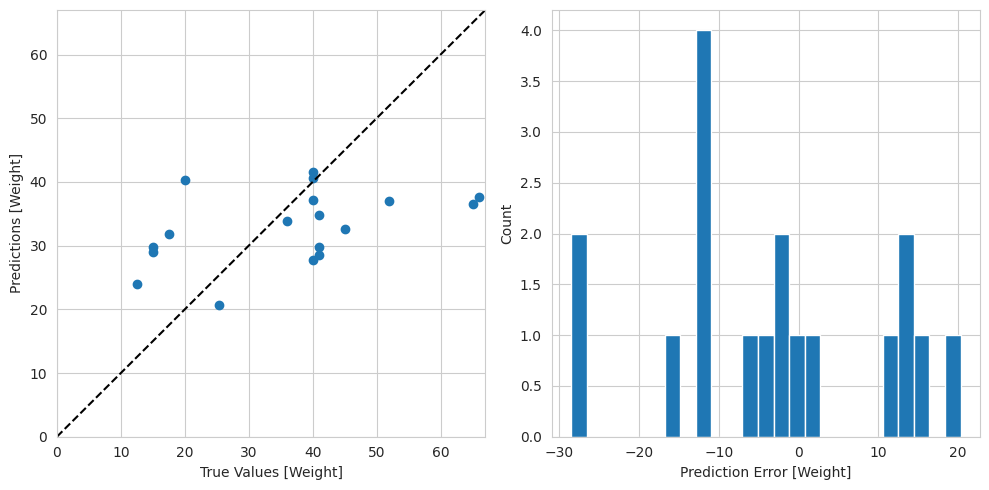

In [16]:
#Normalised the data 
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x.values)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=0)


# Crear el model
model_2 = keras.Sequential([
    keras.layers.Input(shape=(3,)),
    keras.layers.Dense(units=50, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dense(units=1, activation='linear')
])

model_2.summary()

# Building a model
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics=['mean_absolute_percentage_error'])

model_2.fit(X_train, y_train, epochs=500, verbose=1,batch_size=32,validation_split=0.1)

# evaluate
print(f"{model_2.evaluate(X_test,y_test)}")

# Predict the values using the trained model
y_pred = model_2.predict(X_test)

# Calculate and print the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# Save the model
#model_2.save('linear_model')

# Prediction for 20 repetitions
new_session = np.array([[len(dataset), 10,1]])
new_session_scaled = scaler.transform(new_session)
predicted_weight = model_2.predict(new_session_scaled)
print(f"Weight prediction for a new session of {10}: {predicted_weight[0][0]:.2f} kg")


# View predictions vs real values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [Weight]')
plt.ylabel('Predictions [Weight]')
lims = [0, max(y_test.max(), y_pred.max())+1]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims, 'k--')

error = y_pred.flatten() - y_test
plt.subplot(1, 2, 2)
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Weight]')
plt.ylabel('Count')
plt.tight_layout()
plt.show()